In [1]:
import cv2
import os
import numpy as np
import json
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, MultiPolygon

from inference_utils.tiled_segmentation import WindowReadyImage
from inference_utils.mmdet_inference import MMDetectionQueryInstInference
from inference_utils.yolact_inference import YOLACTModel
from inference_utils.young_classifier import YoungWalrusesClassier

%matplotlib inline

In [2]:
def read_image(img_p: str) -> np.ndarray:
    _img = cv2.imread(img_p, cv2.IMREAD_COLOR)
    assert _img is not None, img_p
    return cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)

In [3]:
samplep = '/media/alexey/SSDDataDisk/datasets/walruses/raw/markup/191.json'

with open(samplep, 'r') as jf:
    markup_data = json.load(jf)

In [4]:
markup_data[0]

{'id': 1,
 'segmentation_poly': [[714.0,
   44.5,
   732.0,
   40.5,
   736.0,
   34.5,
   742.5,
   33.0,
   743.5,
   27.0,
   739.5,
   23.0,
   744.5,
   10.0,
   743.0,
   0.5,
   632.5,
   1.0,
   655.0,
   27.5,
   672.0,
   37.5,
   687.0,
   43.5]],
 'bbox': [632.5, 0.5, 112.0, 44.0, 0.0],
 'category_id': 1,
 'tracker_id': None,
 'segmentation': None,
 'comment': '',
 'is_key_frame': True,
 'orientation': None,
 'type': 'poly',
 'tag_list': []}

In [12]:
img = np.ones((100, 100), dtype=np.uint8)*255

contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

list(contours).sort(key=lambda _x: cv2.contourArea(_x))

contours[0].squeeze(1)

array([[ 0,  0],
       [ 0, 99],
       [99, 99],
       [99,  0]], dtype=int32)

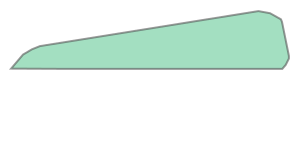

In [12]:
poly1 = Polygon(np.array(markup_data[0]['segmentation_poly']).reshape(-1, 2))
poly2 = Polygon(np.array(markup_data[1]['segmentation_poly']).reshape(-1, 2))

poly1.union(poly2).convex_hull

38 73


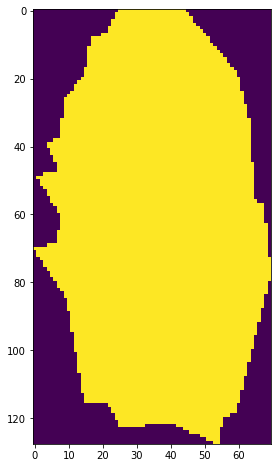

In [8]:
from shapely import ops
from shapely.ops import voronoi_diagram
d = markup_data[9]
poly = Polygon(np.array(d['segmentation_poly']).reshape(-1, 2))

ppoints = np.array(poly.exterior.xy).T.astype(np.float32)
box = cv2.boundingRect(ppoints)
ppoints -= box[:2]
ppoints = np.expand_dims(ppoints, axis=1).astype(np.int0)
a
mask = np.zeros((box[3], box[2]), dtype=np.uint8)
mask = cv2.drawContours(mask, [ppoints], 0, 255, -1)
dres = cv2.distanceTransform(mask, cv2.DIST_L2, 5, cv2.DIST_LABEL_PIXEL)
_, _, _, (cx, cy) = cv2.minMaxLoc(dres, None)

print(cx, cy)

plt.figure(figsize=(8, 8))
plt.imshow(mask)
plt.show()

In [5]:
# inference_f = YOLACTModel()
inference_f = MMDetectionQueryInstInference(conf=0.3)
young_f = YoungWalrusesClassier(conf=0.7)

load checkpoint from local path: /home/alexey/programming/squanch_work/nenets_walruses/inference_utils/../data/epoch_12.pth


In [6]:
sample_image = read_image('/media/alexey/SSDDataDisk/datasets/walruses/raw/images/41.jpg')
pred_sample = WindowReadyImage(
    cv2.cvtColor(sample_image, cv2.COLOR_RGB2BGR), 
    inference_f, 
    young_f,
    700
)

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]/home/alexey/venv/lib/python3.8/site-packages/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/home/alexey/venv/lib/python3.8/site-packages/mmdet/models/roi_heads/sparse_roi_head.py:355: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  bbox_pred_per_img = proposal_list[img_id][topk_indices //
100%|███████████████████████████████████

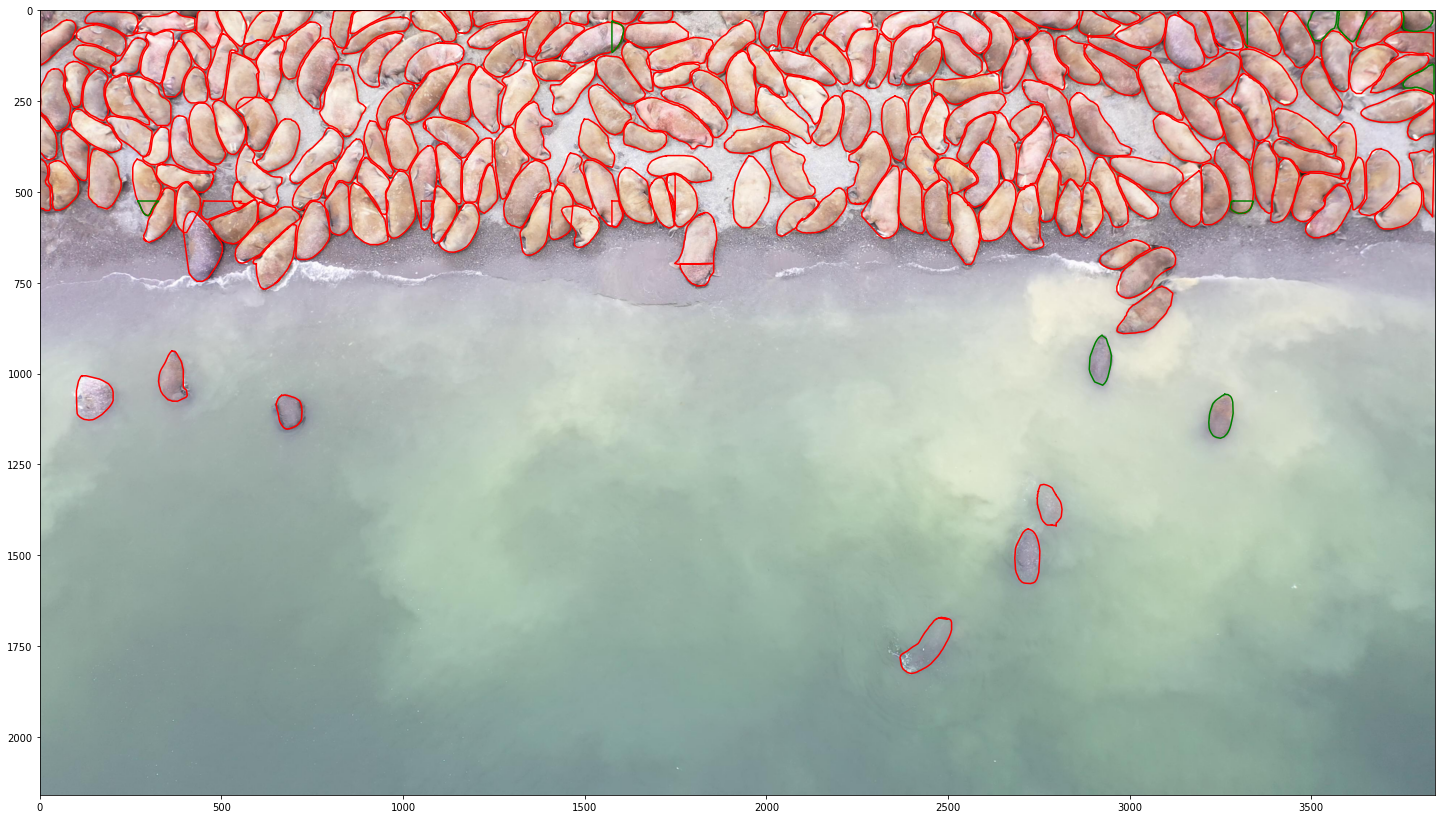

In [7]:
import shapely


plt.figure(figsize=(25, 20))

plt.imshow(sample_image)

for p in pred_sample.detections:
    x, y = p.poly.exterior.xy
    color = 'red' if p.cls == 0 else 'green'
    plt.plot(x, y, c=color)
plt.show()

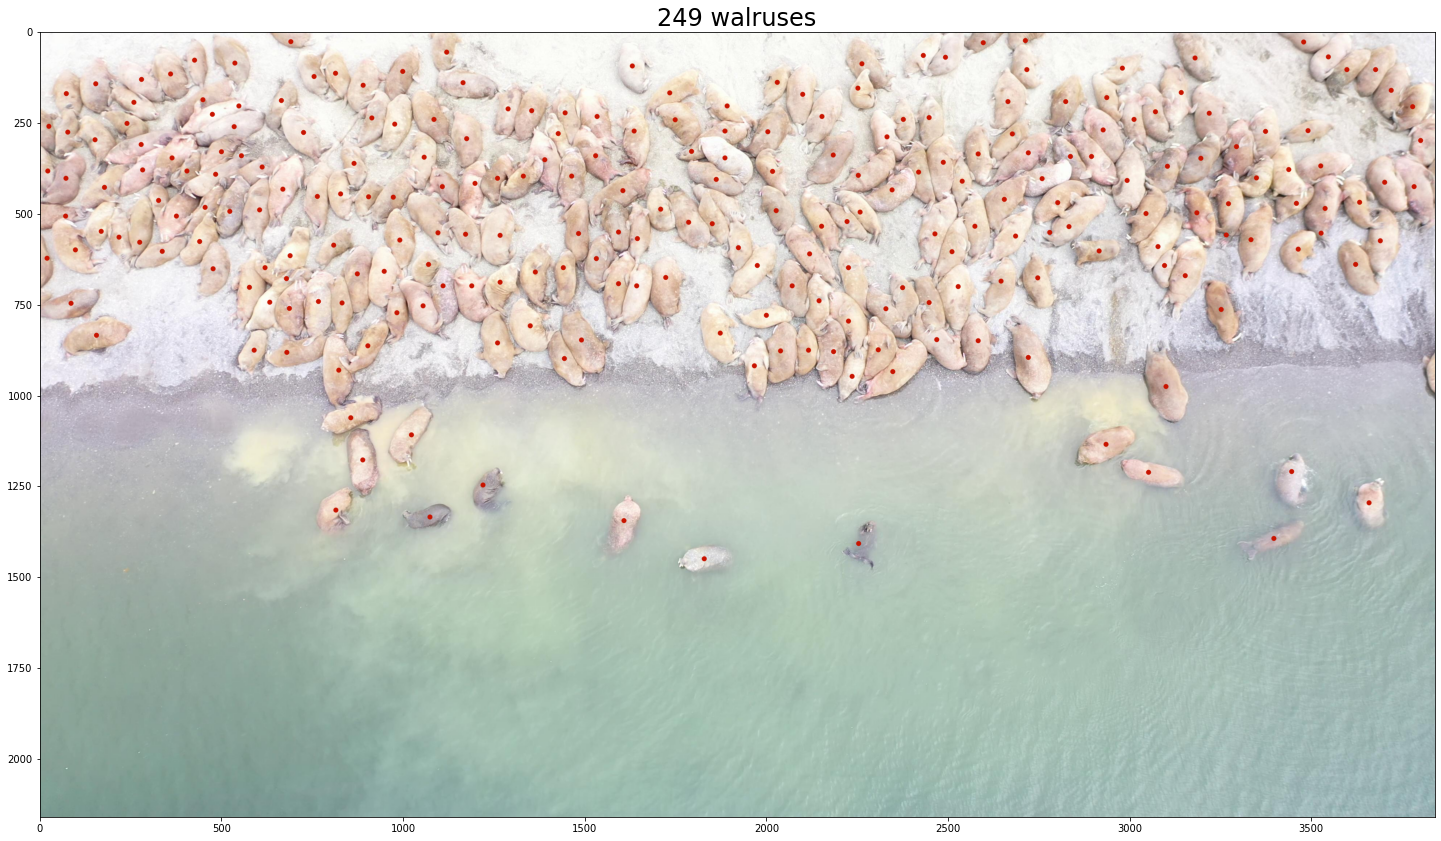

In [33]:
viz_img = sample_image.copy()

points = pred_sample.get_points()
for p in points:
    viz_img = cv2.circle(viz_img, tuple(p), 7, (200, 20, 0), -1)


plt.figure(figsize=(25, 20))
plt.title('{} walruses'.format(len(points)), fontsize=24)
plt.imshow(viz_img)
plt.show()